<a href="https://colab.research.google.com/github/synergit/adversarial-robustness-toolbox/blob/development_issue_1331/sign_opt_CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

In [3]:
import numpy as np

from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


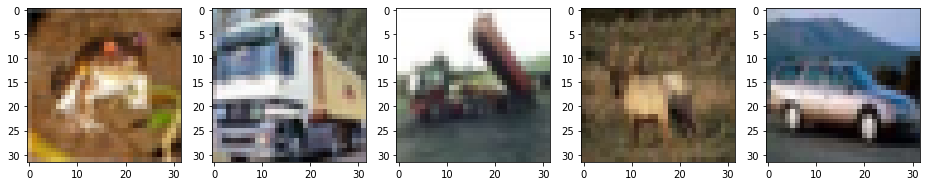

In [14]:
import matplotlib.pyplot as plt
L=5
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:L]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:L]]))

f, axarr = plt.subplots(1, L)
f.set_size_inches(16,6)

for i in range(L):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

In [15]:
# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

X_train /= 255
X_test /= 255

# todo, check /Users/chloe/git/trusted-ai/adversarial-robustness-toolbox/art/utils.py